#**1. Important Libraries**

In [77]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Binarizer

#**2. Load and Prepare the Dataset**

In [78]:
data = 'lung_cancer_prediction_dataset.csv'

# 2. Then load the data
import pandas as pd
df = pd.read_csv(data)

#**3. Create and Transform Features python Copy Edit**

In [79]:
df["Smoking_Index"] = df["Years_of_Smoking"] * df["Cigarettes_per_Day"]


In [80]:
# Convert Yes/No or Male/Female to 0/1
df['Cancer'] = df['Lung_Cancer_Diagnosis'].apply(lambda x: 0 if x == 'No' else 1)
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
df['Smoker'] = df['Smoker'].apply(lambda x: 0 if x == 'No' else 1)
df['Passive_Smoker'] = df['Passive_Smoker'].apply(lambda x: 0 if x == 'No' else 1)
df["Family_History"] = df["Family_History"].apply(lambda x: 0 if x == 'No' else 1)
df["Healthcare_Access"] = df["Healthcare_Access"].apply(lambda x: 0 if x == 'Good' else 1)
df["Developed_or_Developing"] = df["Developed_or_Developing"].apply(lambda x: 0 if x == 'Developing' else 1)
df['Occupational_Exposure'] = df['Occupational_Exposure'].apply(lambda x: 0 if x == 'No' else 1)
df['Indoor_Pollution'] = df['Indoor_Pollution'].apply(lambda x: 0 if x == 'No' else 1)
df['Air_Pollution_Exposure'] = df['Air_Pollution_Exposure'].map({"Low": 0, "Medium": 1, "High": 2})


#**4. Split Cancer vs Non-Cancer Patients**

In [81]:
cancer_df = df[df['Cancer'] == 1]
no_cancer_df = df[df['Cancer'] == 0]

#**5. Sample Balanced Subsets (50% each)**

In [82]:
num_cancer = int(15000 * 0.50)
num_no_cancer = int(15000 * 0.50)

cancer_sample = cancer_df.sample(n=num_cancer, random_state=42)
no_cancer_sample = no_cancer_df.sample(n=num_no_cancer, random_state=42)


#**6. Assign Random Survival Years to Some Non-Cancer Patients**

In [83]:
num_rows_to_modify = 158
rows_to_modify = no_cancer_sample.sample(n=num_rows_to_modify, random_state=42).index

np.random.seed(42)  # ✅ Ensure consistent random survival years
no_cancer_sample.loc[rows_to_modify, "Survival_Years"] = np.random.randint(1, 20, size=num_rows_to_modify)

#**7. Merge Samples & Shuffle Rows**

In [84]:
filtered_df = pd.concat([cancer_sample, no_cancer_sample])
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

#**8. (Optional) One-hot encode pollution exposure**

In [85]:
df = pd.get_dummies(filtered_df, columns=["Air_Pollution_Exposure"], drop_first=True)

#**9. Save Final Clean Dataset**

In [86]:
filtered_df.to_csv('filtered_dataset.csv', index=False)


#**10. Define Target and Features for Modeling**

In [87]:
y = filtered_df['Cancer']
X = filtered_df.drop(columns=[
    'ID', 'Population_Size', 'Country', 'Cancer', 'Lung_Cancer_Diagnosis',
    'Cancer_Stage', 'Adenocarcinoma_Type', 'Early_Detection', 'Treatment_Type',
    'Annual_Lung_Cancer_Deaths', 'Lung_Cancer_Prevalence_Rate', 'Mortality_Rate'
])


#**11. Loading the Filtered Dataset**

In [88]:
X

,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Survival_Years,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Developed_or_Developing,Smoking_Index
0,76,0,0,0,0,0,0,0,1,0,1,1,0,0
1,33,1,1,34,14,0,0,9,1,1,0,1,0,476
2,81,0,0,0,0,0,0,0,1,0,0,1,0,0
3,33,0,0,0,0,0,0,10,1,0,0,1,0,0
4,81,1,1,38,21,0,0,8,0,0,0,0,1,798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,34,1,0,0,0,0,1,3,1,1,0,1,0,0
14996,52,1,0,0,0,0,0,0,0,0,0,1,0,0
14997,84,0,1,12,8,0,0,2,1,1,0,1,0,96
14998,79,1,1,38,12,0,0,6,2,0,1,1,0,456


#**12.Plotting Histogram For Numerical Variables**

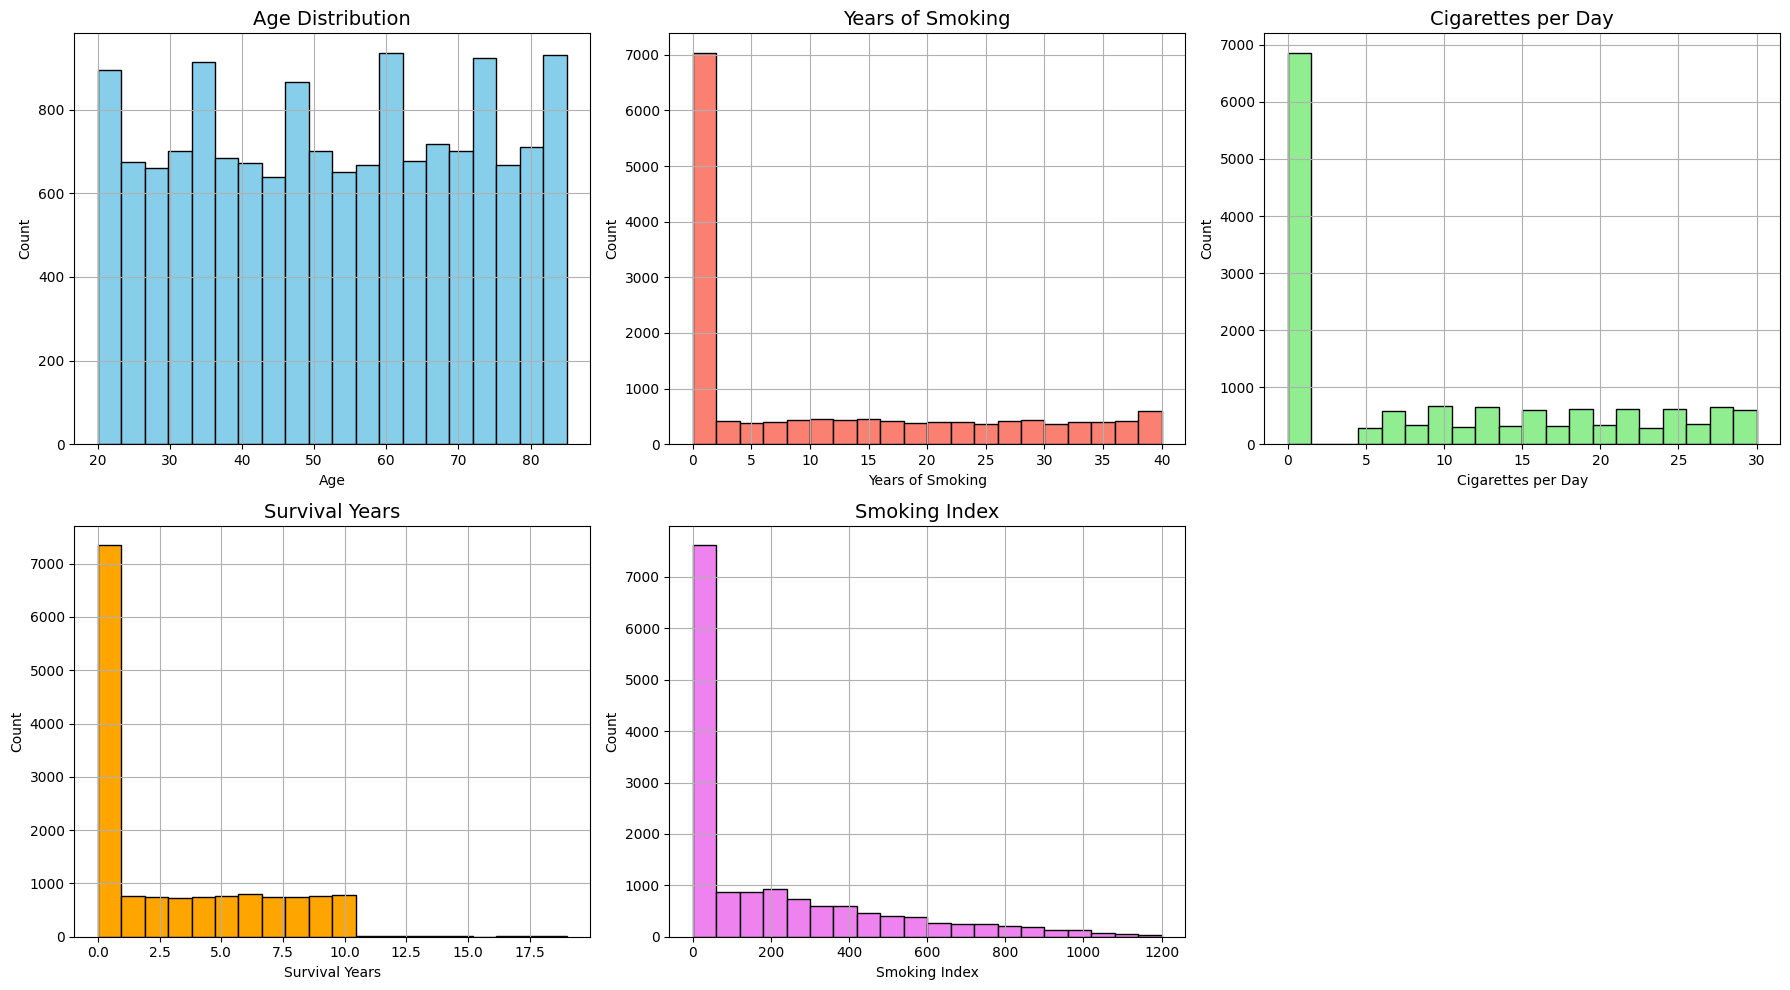

In [89]:
# prompt: plot histogram for the variables "Age","Years_of_Smoking","Cigarettes_per_Day", "Survival_Years" and "Smoking_Index"

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Age
plt.subplot(2, 3, 1)
plt.hist(X['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)

# Years of Smoking
plt.subplot(2, 3, 2)
plt.hist(X['Years_of_Smoking'], bins=20, color='salmon', edgecolor='black')
plt.title('Years of Smoking', fontsize=14)
plt.xlabel('Years of Smoking')
plt.ylabel('Count')
plt.grid(True)

# Cigarettes per Day
plt.subplot(2, 3, 3)
plt.hist(X['Cigarettes_per_Day'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Cigarettes per Day', fontsize=14)
plt.xlabel('Cigarettes per Day')
plt.ylabel('Count')
plt.grid(True)

# Survival Years
plt.subplot(2, 3, 4)
plt.hist(X['Survival_Years'], bins=20, color='orange', edgecolor='black')
plt.title('Survival Years', fontsize=14)
plt.xlabel('Survival Years')
plt.ylabel('Count')
plt.grid(True)

# Smoking Index
plt.subplot(2, 3, 5)
plt.hist(X['Smoking_Index'], bins=20, color='violet', edgecolor='black')
plt.title('Smoking Index', fontsize=14)
plt.xlabel('Smoking Index')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()


#**13.Plotting Bar Plot For Encodded Categorical variables**

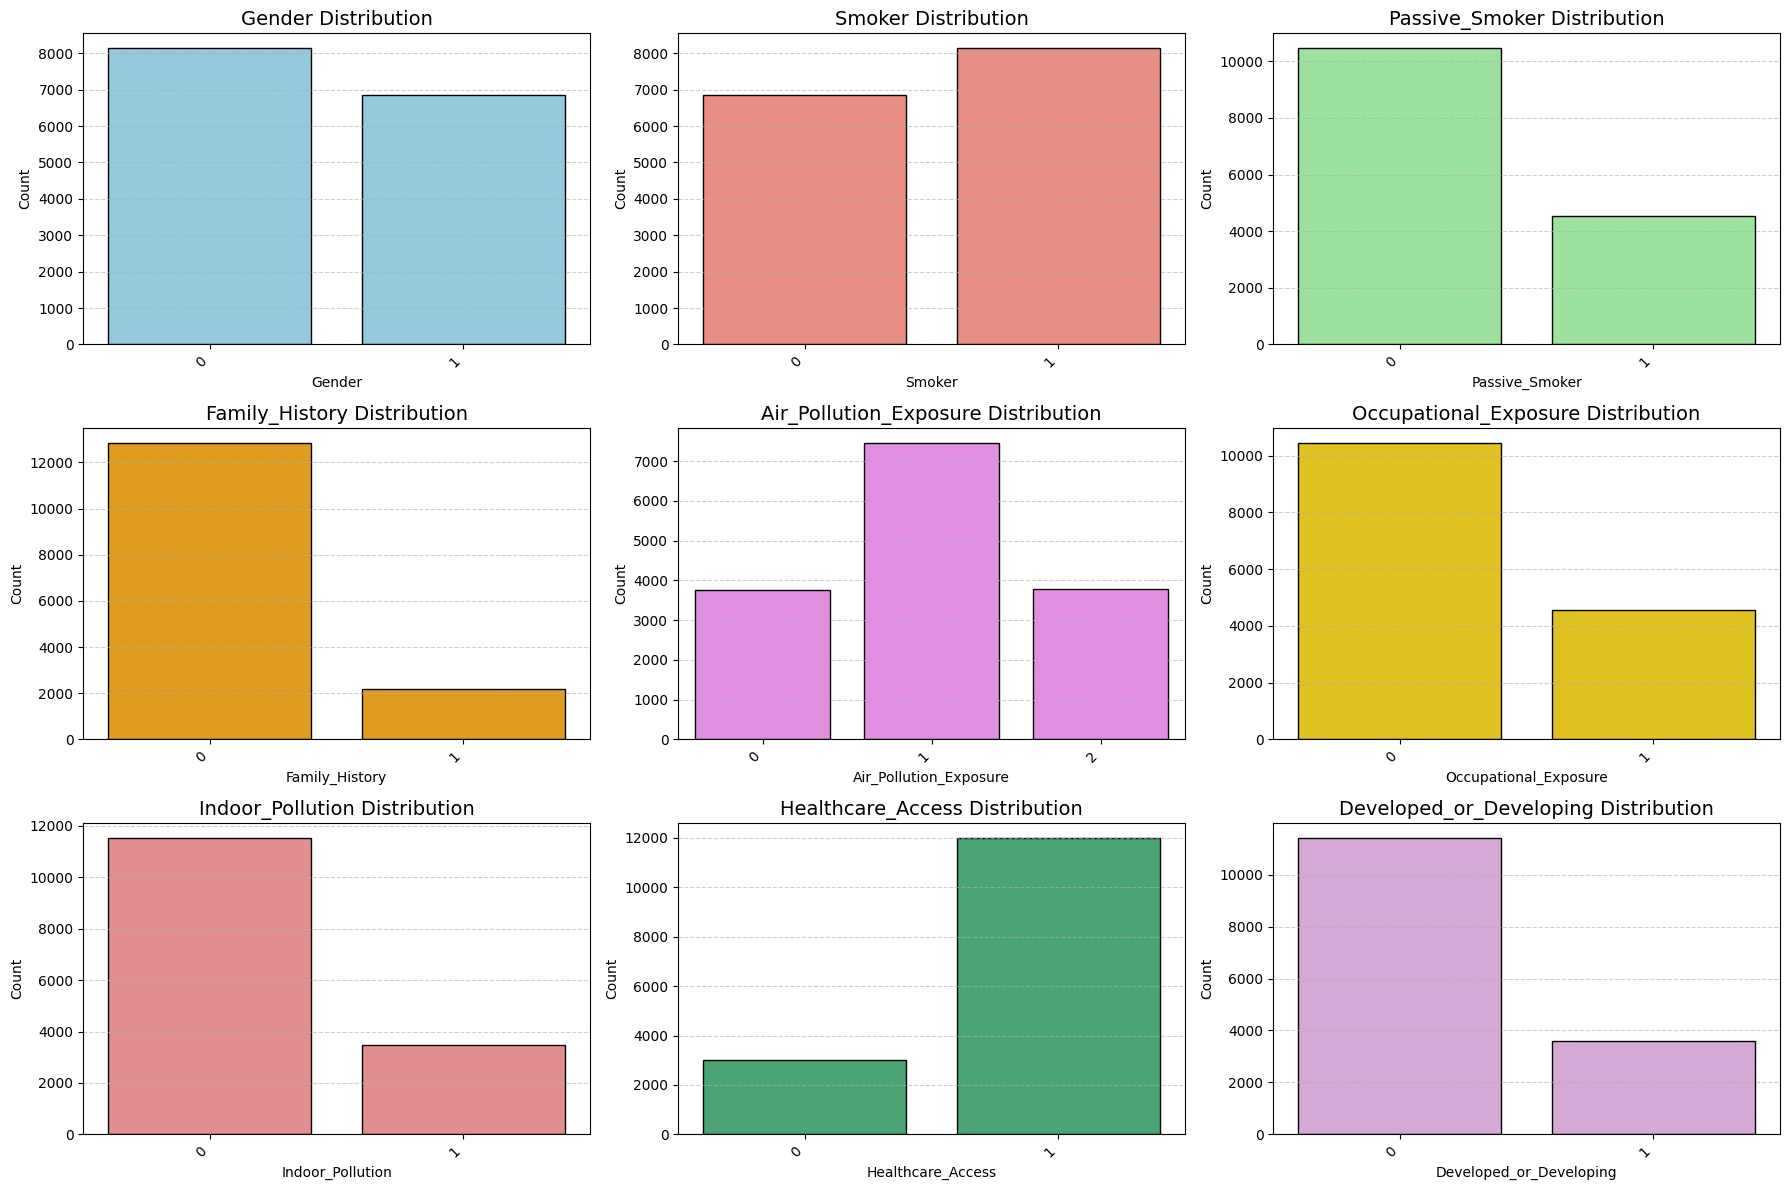

In [90]:
# prompt: plot bar plot for the variables "Gender","Smoker","Passive_Smoker","Family_History", "Air_Pollution_Exposure","Occupational_Exposure", "Indoor_Pollution", "Healthcare_Access", "Developed_or_Developing", ""

import matplotlib.pyplot as plt
import seaborn as sns

variables = [
    "Gender", "Smoker", "Passive_Smoker", "Family_History",
    "Air_Pollution_Exposure", "Occupational_Exposure",
    "Indoor_Pollution", "Healthcare_Access", "Developed_or_Developing"
]

# Define a list of distinct colors
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'violet', 'gold', 'lightcoral', 'mediumseagreen', 'plum']

plt.figure(figsize=(18, 12))

for i, (var, color) in enumerate(zip(variables, colors)):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=var, data=X, color=color, edgecolor="black")
    plt.title(f'{var} Distribution', fontsize=14)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()




#**14.Box plot for all numerical features grouped by Cancer**

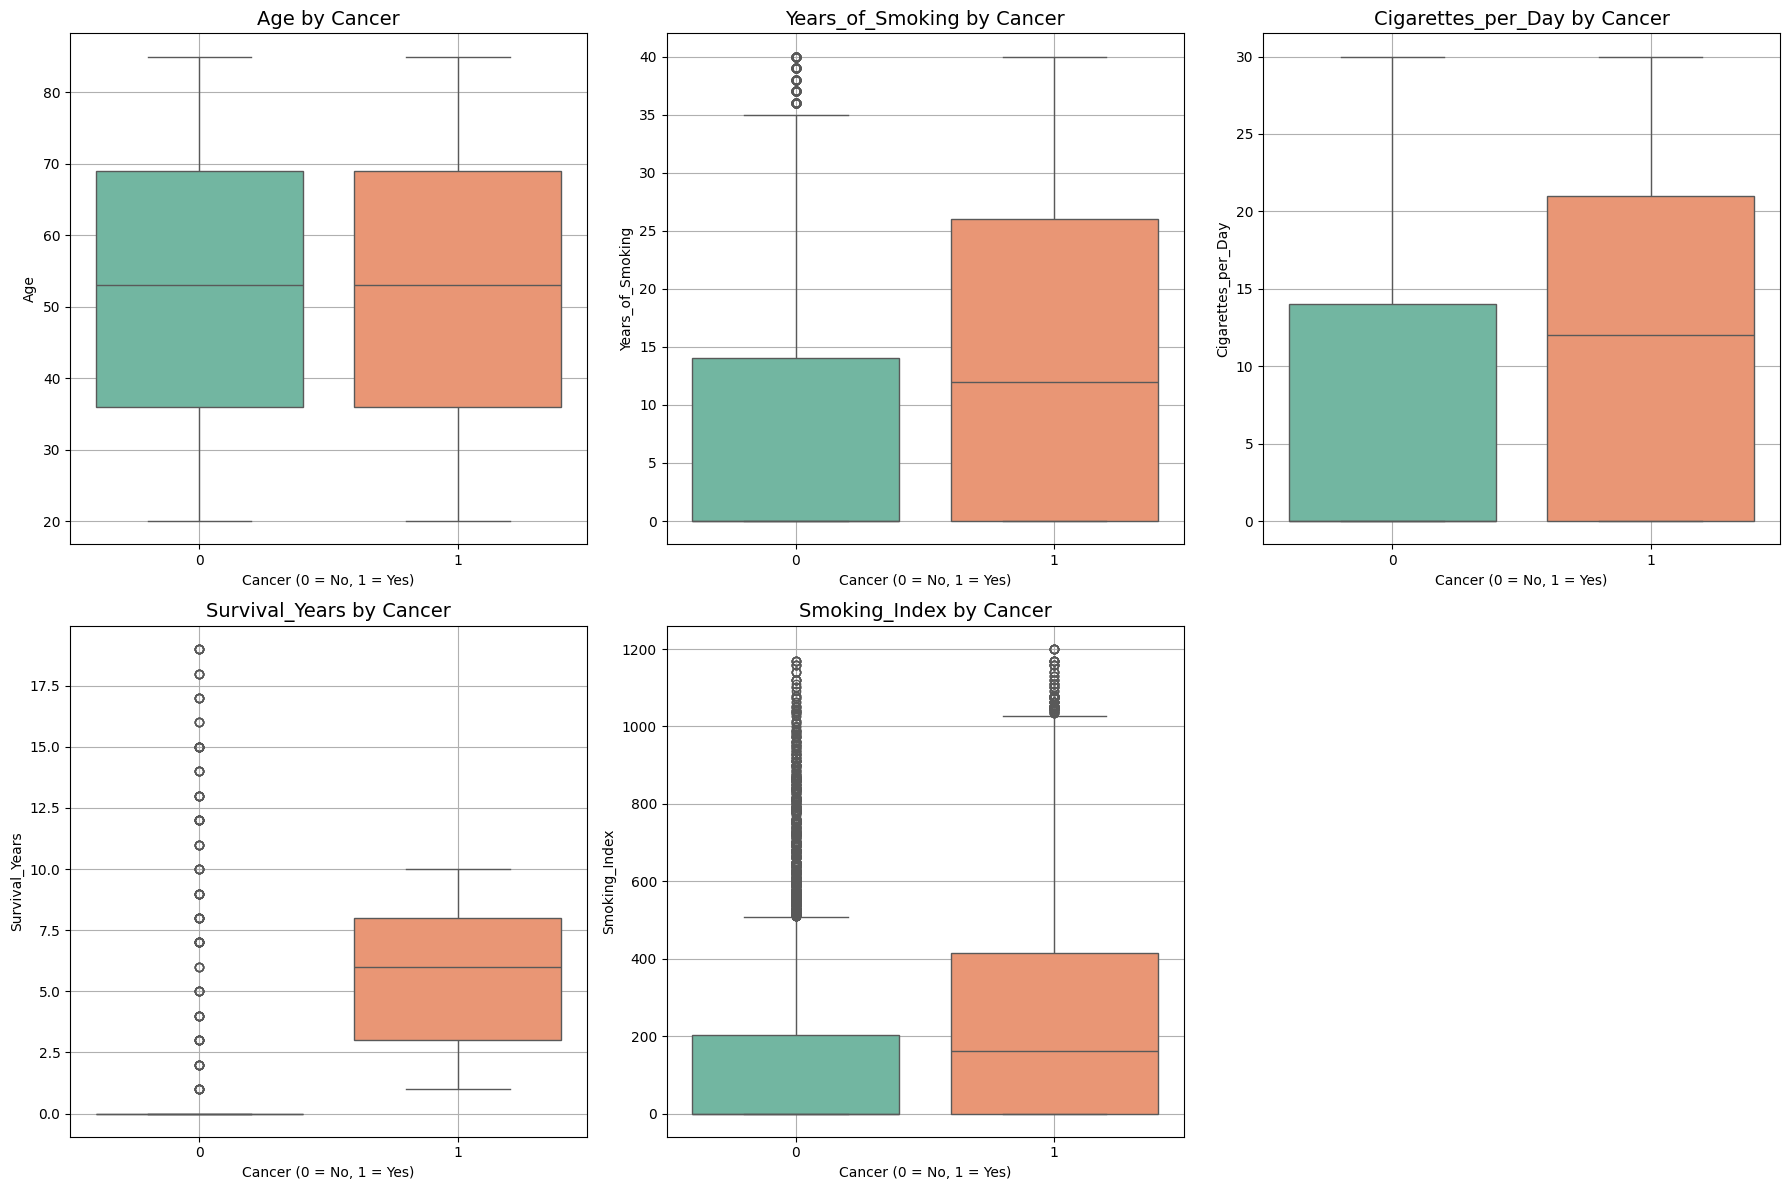

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ["Age", "Years_of_Smoking", "Cigarettes_per_Day", "Survival_Years", "Smoking_Index"]

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=y, y=X[col], hue=y, palette='Set2', legend=False)
    plt.title(f'{col} by Cancer', fontsize=14)
    plt.xlabel('Cancer (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.grid(True)

plt.tight_layout()
plt.show()

#**15.Scatter Plots**

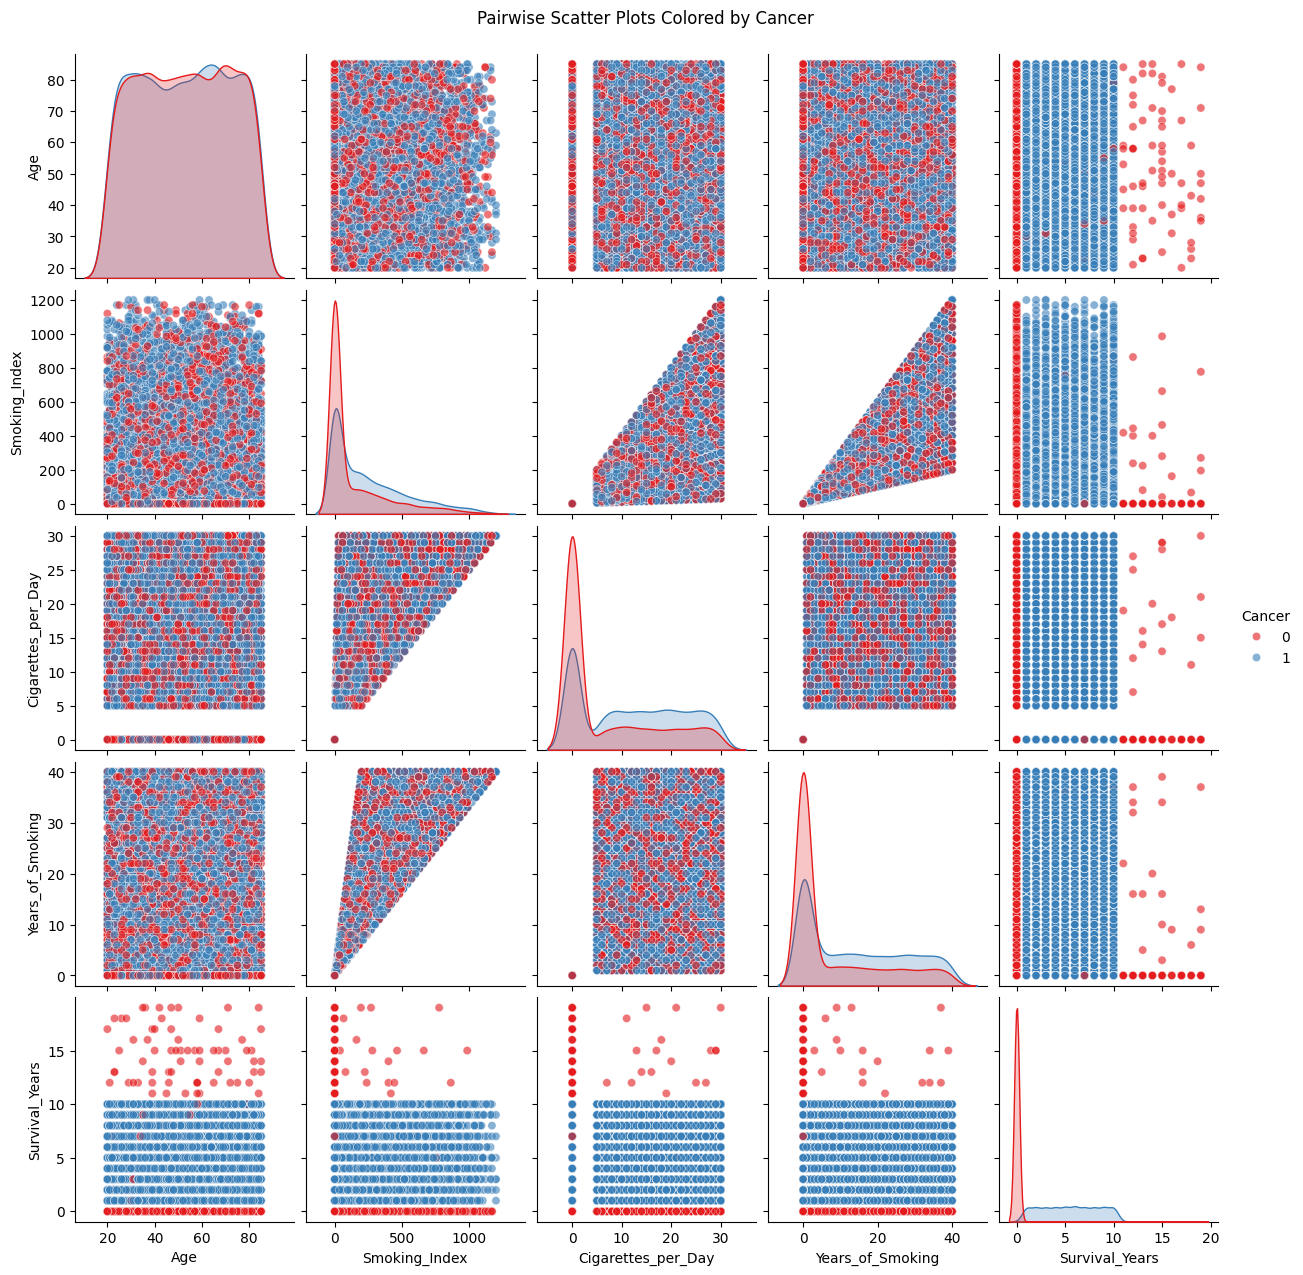

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine numerical features and target into one DataFrame
df_plot = X[["Age", "Smoking_Index", "Cigarettes_per_Day", "Years_of_Smoking", "Survival_Years"]].copy()
df_plot["Cancer"] = y

# Pair plot with color by Cancer
sns.pairplot(df_plot, hue="Cancer", palette="Set1", plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Scatter Plots Colored by Cancer", y=1.02)
plt.show()


#**16. Plot the Correlation Heat Map**

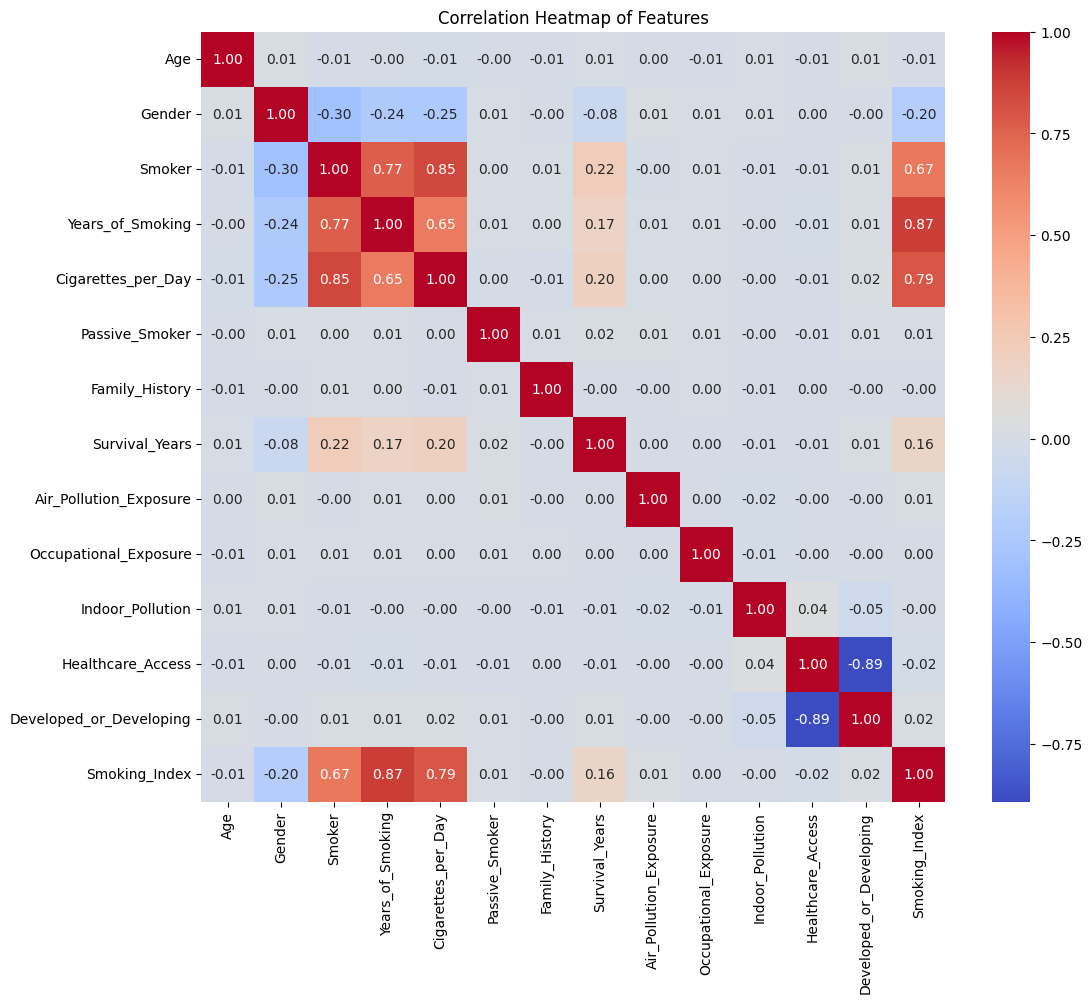

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X' is your DataFrame as defined in the previous code.
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

#**17. Applying Bayesian Ridge**

Since  Bayesian Ridge is a regression model, it outputs probabilities-like values, not class labels. So, the predictions must be thresholded manually to turn them into actual class labels. For instance, the Bayesian Ridge gives results like:[0.12, 0.60, 0.45, 0.81, 0.33] which are not class labels, they are scores or probabilities. So we need a cut-off point — that’s what the threshold is.

Threshold 0.45 means:

"If the predicted value is greater than or equal to 0.45, call it 1 (Cancer). Otherwise, call it 0 (No Cancer)."



**Cross-validation** gives the model a real-world test by training it on different parts of the data and checking how well it does on all possible test scenarios — it's smarter and fairer than one-time testing.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Separate numerical and categorical features
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = [col for col in X.columns if col not in num_cols or X[col].nunique() == 2]  # Keep binary unscaled

# Scale only numerical features
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols, index=X.index)



# Combine scaled numerical + unscaled categorical features
X_preprocessed = pd.concat([X_num_scaled, X[cat_cols]], axis=1)

# Train Bayesian Ridge
bayes_ridge = BayesianRidge()
y_pred_probs_cv = cross_val_predict(bayes_ridge, X_preprocessed, y, cv=5, method='predict')


# Threshold and evaluate
y_pred_cv = (y_pred_probs_cv >= 0.30).astype(int)

print("Cross-Validated Accuracy:", accuracy_score(y, y_pred_cv))
print("\nCross-Validated Classification Report:\n", classification_report(y, y_pred_cv))

Cross-Validated Accuracy: 0.9728666666666667

Cross-Validated Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      7500
           1       0.97      0.97      0.97      7500

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



Based on the result: Now the Bayesian Ridge model shows that **97%** of all **15000** predictions were correct, on average across the 5 cross-validation folds. As you now, we already splitted dataset to two groups 0(No Cnacer) and 1(cancer), each group includes 7500 patients.  


Let me break it down deeply for Class 0:

precision: 0.97
recall:    0.98
f1-score:  0.98
support:   7500

Precision (97%): When the model said No Cancer, it was right 86% of the time.

Recall (98%): Out of all actual No Cancer patients, it found 98% of them correctly.

F1-score (98%): A balance between precision and recall.

Support: 7500 people in this group (actual No Cancer cases).


I did **5-fold cross-validation(cv=5)**, and got predictions from every fold. Then I applied a threshold to those predictions to convert them to 0 and 1.

Let me give you an example about the concept of **Cross validation:**

You have a dataset of 100 people.

If you just split it like this:

70 people for training

30 people for testing

Then your model only sees one view of the data.
What if those 30 test people aren’t typical? Your accuracy might be misleading.

Cross-validation solves this:

Instead of testing on just one group, it does this:

Split the data into 5 equal parts (called "folds").

Train on 4 parts, test on the 1 left out.

Repeat 5 times, so each fold gets to be the test set once.

Take the average of all 5 results → that’s your real score.



| Fold | Training data | Test data |
| ---- | ------------- | --------- |
| 1    | Folds 2,3,4,5 | Fold 1    |
| 2    | Folds 1,3,4,5 | Fold 2    |
| 3    | Folds 1,2,4,5 | Fold 3    |
| 4    | Folds 1,2,3,5 | Fold 4    |
| 5    | Folds 1,2,3,4 | Fold 5    |



Then you average the accuracy (or F1 score, etc.) from all 5 tests.


#**18.Feature Importance For Bayesian Regression**

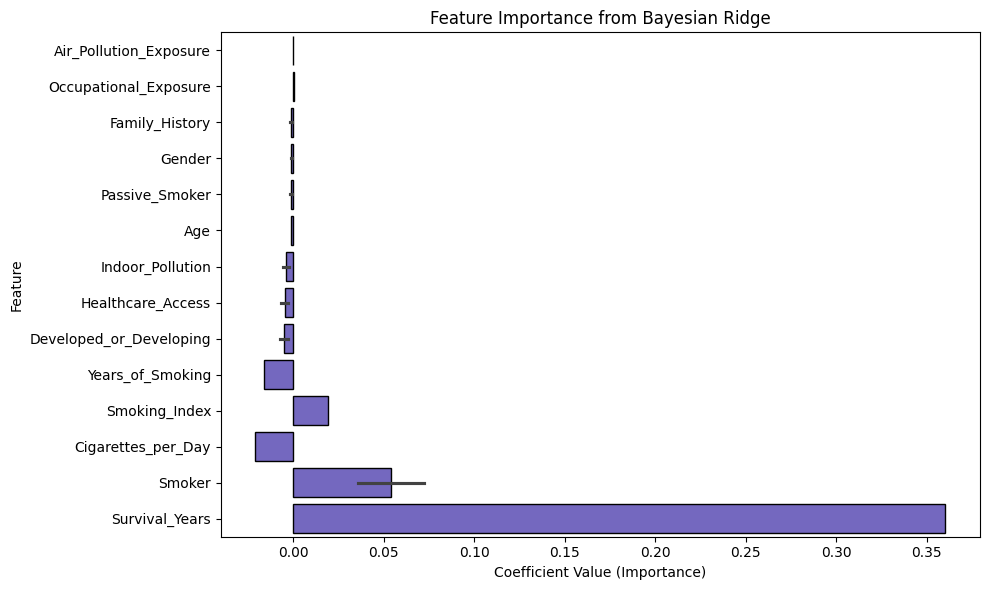

In [95]:
# === Feature Importance for Bayesian Ridge ===

# Retrain the model on full data to access coefficients
bayes_ridge.fit(X_preprocessed, y)

# Extract coefficients (feature importances)
importance_values = pd.Series(bayes_ridge.coef_, index=X_preprocessed.columns)

# Sort by absolute importance
importance_values = importance_values.sort_values(key=abs, ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=importance_values.index, color='slateblue', edgecolor='black')
plt.title('Feature Importance from Bayesian Ridge')
plt.xlabel('Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


| Feature                                                      | Meaning in the Plot                                                                                                                         |
| ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `Survival_Years`                                             | Has the **highest positive influence** on predicting cancer. Longer survival time is strongly associated with cancer presence in your data. |
| `Smoker`                                                     | Strong predictor: being a smoker increases cancer likelihood (positive coefficient).                                                        |
| `Cigarettes_per_Day`, `Smoking_Index`, `Years_of_Smoking`    | Contribute moderately to predictions — logically expected.                                                                                  |
| Features like `Healthcare_Access`, `Indoor_Pollution`, `Age` | Smaller bars → less influential in the current model.                                                                                       |
| Features like `Air_Pollution_Exposure`, `Gender`, etc.       | Very short bars, close to zero → almost **no effect** in prediction (in this model).                                                        |


Based on the table:

The model finds that Survival_Years, Smoker, and Cigarettes_per_Day are the most useful variables to distinguish cancer vs. no cancer. Features like Gender or Air_Pollution_Exposure were less informative in this particular training run.

#**19. Plot the Confusion Matrix for Bayesian Ridge**


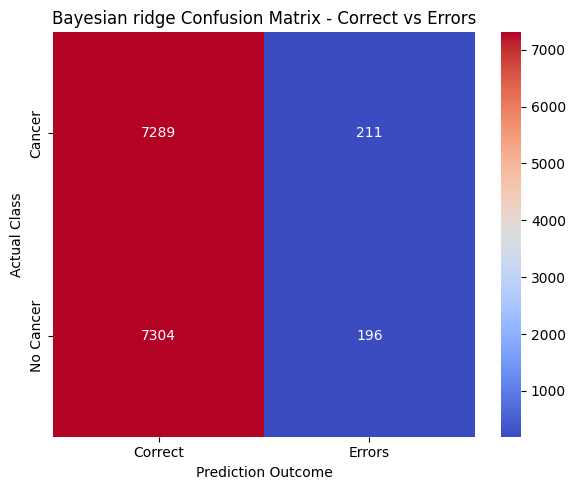

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix from cross-validation predictions
cm_cv = confusion_matrix(y, y_pred_cv)

# Create a custom view: [Cancer, No Cancer] vs [Correct, Errors]
custom_cm_cv = np.array([
    [cm_cv[1, 1], cm_cv[1, 0]],  # Actual Cancer: [TP, FN]
    [cm_cv[0, 0], cm_cv[0, 1]]   # Actual No Cancer: [TN, FP]
])

# Plotting the matrix
plt.figure(figsize=(6, 5))
sns.heatmap(custom_cm_cv, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Correct', 'Errors'],
            yticklabels=['Cancer', 'No Cancer'])
plt.title('Bayesian ridge Confusion Matrix - Correct vs Errors')
plt.xlabel('Prediction Outcome')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()


#Based on the Confusion Matrix Result for Bayesian Ridge Model:
7304 people who didn't have cancer were correctly predicted

196 people who didn't have cancer were wrongly predicted to have cancer

7289 people who did have cancer were correctly identified

211 people who did have cancer were missed

#**20.Applying Logistic Regression**

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning


# Scale only numerical features
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols, index=X.index)


# Combine scaled numerical + unscaled categorical features
X_preprocessed = pd.concat([X_num_scaled, X[cat_cols]], axis=1)

# Train Logistic regression
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs')

# Cross-validated probability predictions
y_pred_probs_logreg = cross_val_predict(log_reg, X_preprocessed, y, cv=5, method='predict_proba')[:, 1]

# Apply threshold to get binary predictions
y_pred_logreg = (y_pred_probs_logreg >= 0.3).astype(int)

# Evaluation
print("Logistic Regression Cross-Validated Accuracy:", accuracy_score(y, y_pred_logreg))
print("\nLogistic Regression Classification Report:\n", classification_report(y, y_pred_logreg))


Logistic Regression Cross-Validated Accuracy: 0.9758666666666667

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      7500
           1       0.98      0.97      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



#**21.Confusion Matrix for Logistic regression**

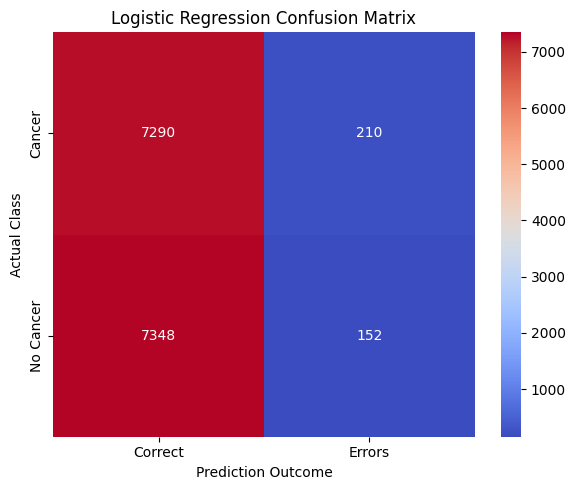

In [98]:
# Confusion Matrix
cm_logreg = confusion_matrix(y, y_pred_logreg)
custom_cm_logreg = np.array([
    [cm_logreg[1, 1], cm_logreg[1, 0]],  # [TP, FN]
    [cm_logreg[0, 0], cm_logreg[0, 1]]   # [TN, FP]
])

plt.figure(figsize=(6, 5))
sns.heatmap(custom_cm_logreg, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Correct', 'Errors'],
            yticklabels=['Cancer', 'No Cancer'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Prediction Outcome')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

#**22.Feature Importance For logistic Regression**

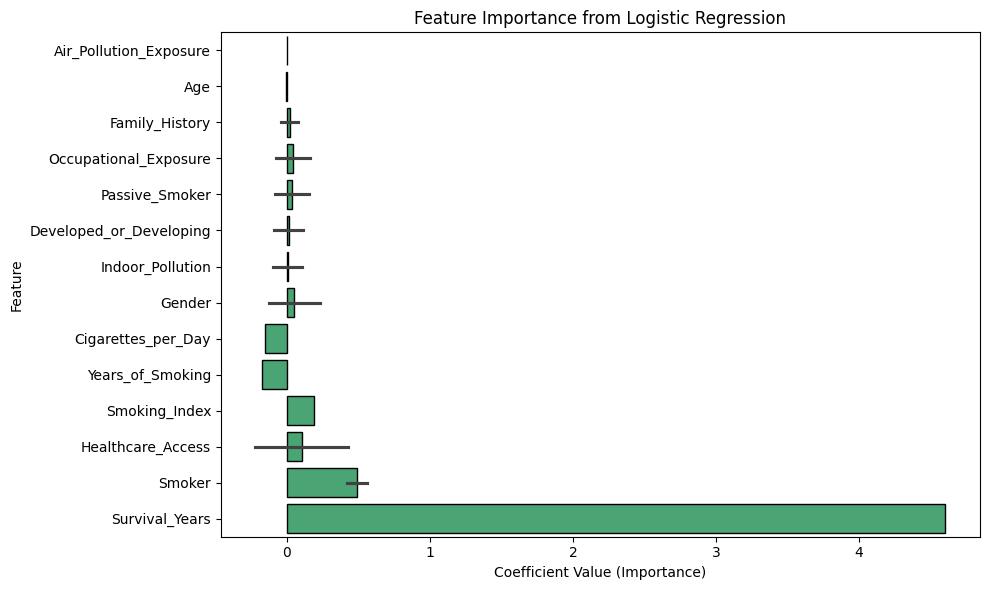

In [99]:
# === Feature Importance for Logistic Regression ===

# Retrain Logistic Regression on the full preprocessed dataset
log_reg.fit(X_preprocessed, y)

# Extract coefficients
importance_values = pd.Series(log_reg.coef_[0], index=X_preprocessed.columns)

# Sort by absolute importance
importance_values = importance_values.sort_values(key=abs, ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=importance_values.index, color='mediumseagreen', edgecolor='black')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


#**23.Applying Random Forest**#

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

# Train Random Forest with cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred_probs_rf = cross_val_predict(rf_model, X, y, cv=5, method='predict_proba')[:, 1]

# Threshold to get binary predictions
y_pred_rf = (y_pred_probs_rf >= 0.3).astype(int)

# Evaluate model
print("Random Forest Cross-Validated Accuracy:", accuracy_score(y, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y, y_pred_rf))




Random Forest Cross-Validated Accuracy: 0.9905333333333334

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      7500
           1       0.98      1.00      0.99      7500

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



#**24.Confusion Matrix for Random Forest**

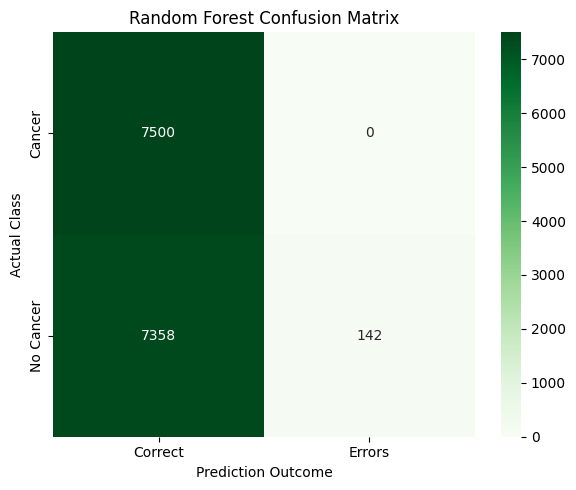

In [101]:
# Confusion matrix
cm_rf = confusion_matrix(y, y_pred_rf)

# Rearranged format: [Correct, Error]
custom_cm_rf = np.array([
    [cm_rf[1, 1], cm_rf[1, 0]],  # Cancer: [True Positive, False Negative]
    [cm_rf[0, 0], cm_rf[0, 1]]   # No Cancer: [True Negative, False Positive]
])

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(custom_cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Correct', 'Errors'],
            yticklabels=['Cancer', 'No Cancer'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Prediction Outcome')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

As you can see the Random Forest offers the best result compared to two other methodologies such as Bayesian Ridge and logistic regression. **The Random Forest accuracy is 99%**. **It also shows the best result for confusion matrix so that the Random Forest predicts the patients who have cancer without any Erorr**. It implys how power ful this model is. **It is worthwhile to mention that despite Bayesian Ridge and logistic Regression models, the Random Forest model does not need standardization as the random Forest is based on decision tree.** In fact, it splits data based on the feature values, not distance. For instance, the Random Forest uses thresholds like “is Age > 45?”, not mathematical magnitudes.

#**25.Feature Importance For random Forest**

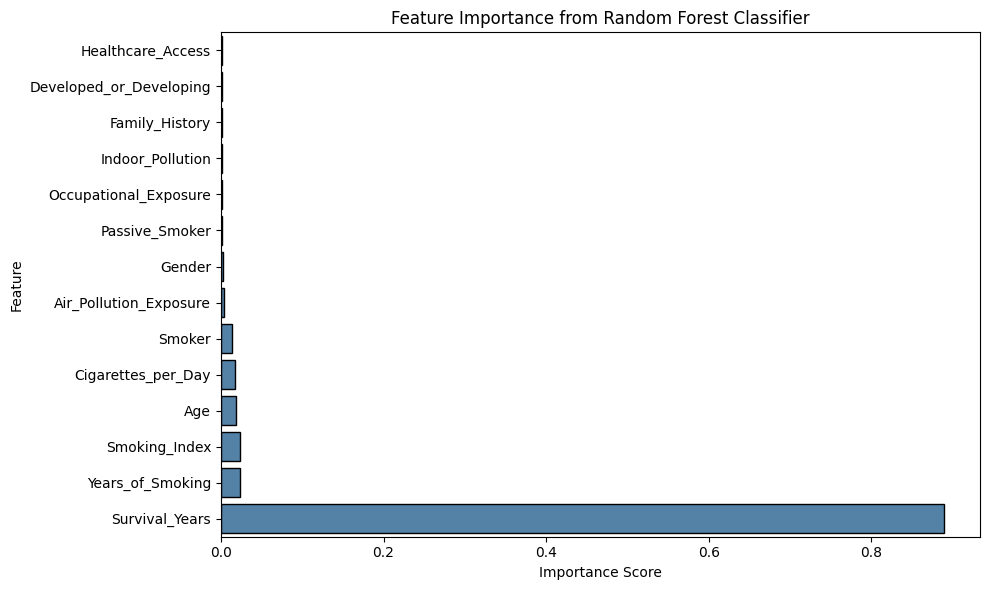

In [102]:
# === Train Random Forest Classifier and Plot Feature Importances ===
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, color='steelblue', edgecolor='black')
plt.title('Feature Importance from Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



**Why Do We Have to Re-Fit the Model?**

cross_val_predict(...) performs internal k-fold splits and makes predictions without keeping the trained models. So after cross_val_predict, you don’t have access to a trained model object with .feature_importances_.